let's go ahead and implement a simple GAN that generates digits from 0-9, a pretty classic example.

Note that this experiment is purely based on tensorflow, we haven't used Keras backend so that we can have an independent excersise 

#### **Importing Packages**
In the Colab menu, select **Runtime > Change runtime type** and then select **GPU**. Connection to the runtime will happen automatically on first execution, or you can use the "Connect" button in the upper-right corner.



In [ ]:
# using Tensorflow 1
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.15.2


### Auxiliary functions

In [ ]:
mnist=input_data.read_data_sets("MNIST_data")


# Sample z from uniform distribution
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


###Implementation

We can now define the placeholder for our input samples and noise vectors:


In [ ]:
tf.reset_default_graph()
# Input image, for discriminator model.
real_images=tf.placeholder(tf.float32,shape=[None,784])

# Input noise for generator.
z=tf.placeholder(tf.float32,shape=[None,100])

Now, we define our generator and discriminator networks. They are simple perceptrons with dense layers.

In [ ]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1=tf.layers.dense(inputs=z,units=128,activation=tf.nn.leaky_relu)
        hidden2=tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
        output=tf.layers.dense(inputs=hidden2,units=784,activation=tf.nn.tanh)
        
        return output
    
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1=tf.layers.dense(inputs=X,units=128,activation=tf.nn.leaky_relu)
        hidden2=tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
        logits=tf.layers.dense(hidden2,units=1)
        output=tf.sigmoid(logits)
        
        return output,logits

G=generator(z)
D_output_real,D_logits_real=discriminator(real_images)
D_output_fake,D_logits_fake=discriminator(G,reuse=True)


We can now define our models, loss functions and optimizers:

In [ ]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

D_real_loss=loss_func(D_logits_real,tf.ones_like(D_logits_real)*0.9) #Smoothing for generalization
D_fake_loss=loss_func(D_logits_fake,tf.zeros_like(D_logits_real))
D_loss=D_real_loss+D_fake_loss

G_loss= loss_func(D_logits_fake,tf.ones_like(D_logits_fake))
lr=0.001

#Do this when multiple networks interact with each other
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]

D_trainer=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
G_trainer=tf.train.AdamOptimizer(lr).minimize(G_loss,var_list=g_vars)


Finally, we can write out training routine. At each iteration, we perform one step of optimization for the discriminator and one for the generator.

In [ ]:
batch_size=100
epochs=200
init=tf.global_variables_initializer()

samples=[] #generator examples

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        num_batches=mnist.train.num_examples//batch_size
        for i in range(num_batches):
            batch=mnist.train.next_batch(batch_size)
            batch_images=batch[0].reshape((batch_size,784))
            batch_images=batch_images*2-1
            batch_z=np.random.uniform(-1,1,size=(batch_size,100))
            _,D_loss_curr=sess.run([D_trainer,D_loss],feed_dict={real_images:batch_images,z:batch_z})
            _,G_loss_curr=sess.run([G_trainer, G_loss],feed_dict={z:batch_z})
            
        print("on epoch{}".format(epoch))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G loss: {:.4}'. format(G_loss_curr))
        sample_z=np.random.uniform(-1,1,size=(1,100))
        gen_sample=sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        samples.append(gen_sample)

on epoch0
D loss: 0.9093
G loss: 4.276
on epoch1
D loss: 3.53
G loss: 2.505
on epoch2
D loss: 2.003
G loss: 12.29
on epoch3
D loss: 0.6481
G loss: 4.316
on epoch4
D loss: 0.7403
G loss: 2.266
on epoch5
D loss: 1.137
G loss: 10.33
on epoch6
D loss: 1.484
G loss: 1.827
on epoch7
D loss: 1.66
G loss: 1.236
on epoch8
D loss: 1.427
G loss: 0.909
on epoch9
D loss: 1.406
G loss: 1.6
on epoch10
D loss: 1.016
G loss: 2.656
on epoch11
D loss: 0.9636
G loss: 1.642
on epoch12
D loss: 0.677
G loss: 2.322
on epoch13
D loss: 1.476
G loss: 3.114
on epoch14
D loss: 1.103
G loss: 2.083
on epoch15
D loss: 1.711
G loss: 1.787
on epoch16
D loss: 1.202
G loss: 2.517
on epoch17
D loss: 0.8989
G loss: 2.577
on epoch18
D loss: 0.6614
G loss: 2.943
on epoch19
D loss: 1.113
G loss: 3.293
on epoch20
D loss: 1.536
G loss: 3.105
on epoch21
D loss: 0.9825
G loss: 2.034
on epoch22
D loss: 1.221
G loss: 1.992
on epoch23
D loss: 1.63
G loss: 2.975
on epoch24
D loss: 0.8625
G loss: 3.097
on epoch25
D loss: 0.9968
G loss

### **Results**
Q: In the above code one sample digit is generated at the end of each epoch and is saved in "samples". Show some sample results from different epoches. During the first epoches, all you can see is random noise. You can see how our digits are taking shape after several epoches! You might increase the number of training epoches to get more natural looking digits.

In [ ]:
print(gen_sample)
type(gen_sample)

[[-0.99983275 -0.99999994 -0.99977225 -0.99999994 -0.9998462  -0.99995977
  -0.9999967  -0.9999822  -0.9999917  -0.99954635 -0.9999996  -0.99962586
  -0.99997723 -0.99925447 -0.99999946 -0.99997365 -0.99957824 -0.9999993
  -0.99981666 -0.99999994 -0.99999183 -0.99999523 -0.9996807  -0.99892235
  -0.8314185  -0.9981949  -0.9999352  -0.9999842  -0.999995   -0.9999649
  -0.99998707 -0.9984776  -0.9999999  -0.9999999  -0.9999813  -0.99998796
  -0.9999048  -0.9995061  -0.9999351  -0.9996508  -0.99998236 -0.99999785
  -0.9283116  -0.99996746 -0.99998003 -0.99557674 -0.9999978  -0.999954
  -0.98911726 -0.9999802  -0.9998381  -0.9761009  -1.         -0.999992
  -0.99999994 -0.9999999  -0.99731314 -0.9997365  -0.998965   -0.99999946
  -0.9999705  -0.9999948  -0.9992597  -0.9999914  -0.99999815 -0.9999945
  -0.9999978  -0.99999243 -0.9999715  -0.99999577 -0.9999256  -0.9999779
  -0.99992764 -0.99999875 -0.99999964 -0.96210134 -0.9993827  -0.9999927
  -0.99989325 -0.99988693 -0.9999898  -0.999999

numpy.ndarray


Epoch no: 0 



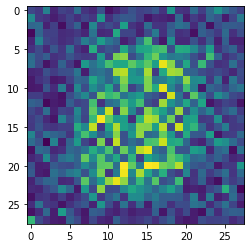


Epoch no: 10 



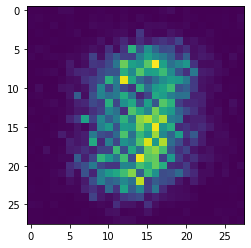


Epoch no: 20 



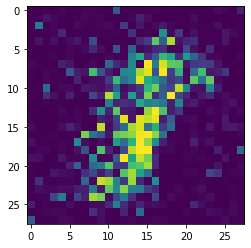


Epoch no: 30 



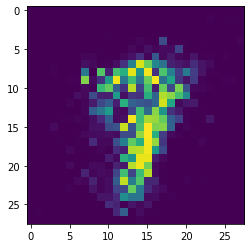


Epoch no: 40 



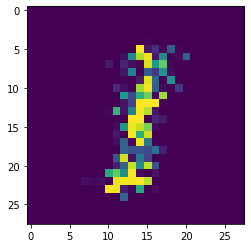


Epoch no: 50 



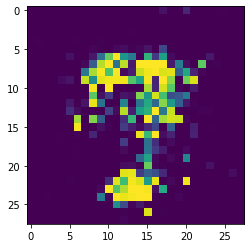


Epoch no: 60 



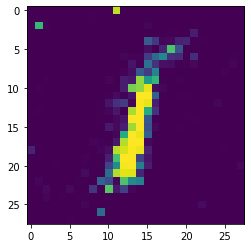


Epoch no: 70 



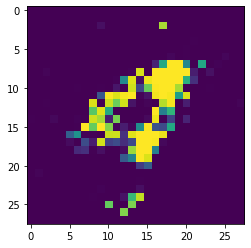


Epoch no: 80 



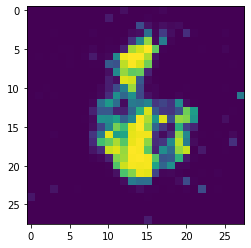


Epoch no: 90 



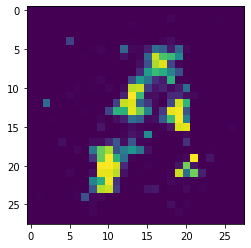


Epoch no: 100 



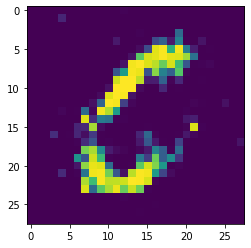


Epoch no: 110 



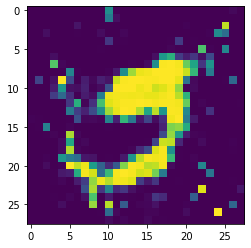


Epoch no: 120 



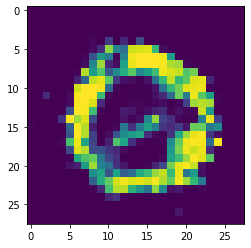


Epoch no: 130 



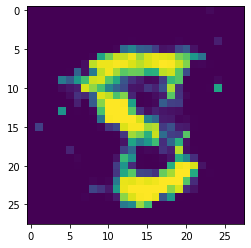


Epoch no: 140 



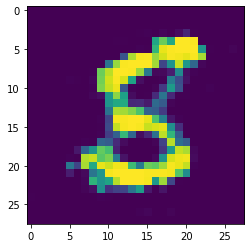


Epoch no: 150 



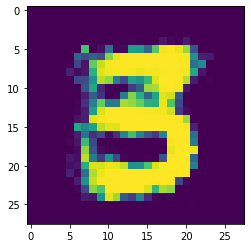


Epoch no: 160 



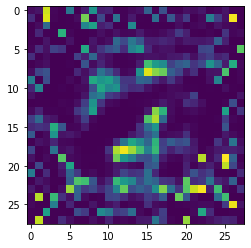


Epoch no: 170 



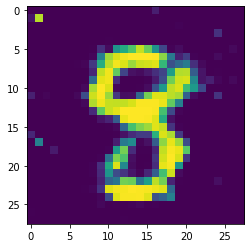


Epoch no: 180 



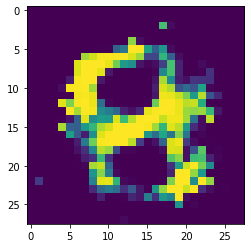


Epoch no: 190 



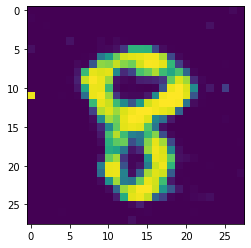

In [ ]:
for i in range(200):
    if i%10==0:
        print('\nEpoch no:',i,'\n')
        plt.imshow(samples[i].reshape(28,28))
        plt.show()

In [ ]:
gen_sample=tf.convert_to_tensor(gen_sample)

In [ ]:
print(gen_sample)

Tensor("Const_3:0", shape=(1, 784), dtype=float32)


In [ ]:
import matplotlib
from matplotlib import gridspec

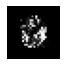

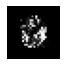

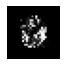

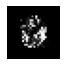

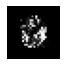

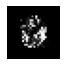

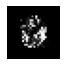

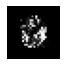

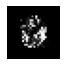

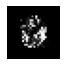

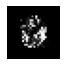

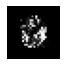

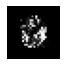

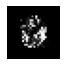

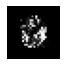

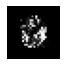

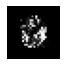

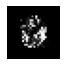

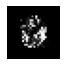

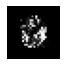

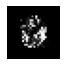

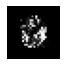

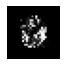

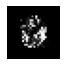

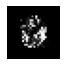

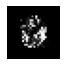

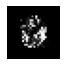

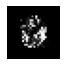

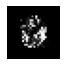

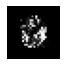

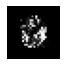

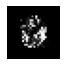

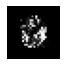

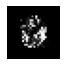

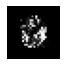

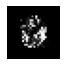

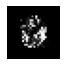

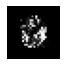

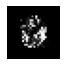

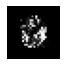

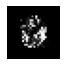

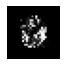

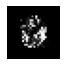

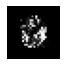

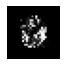

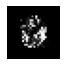

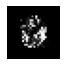

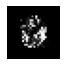

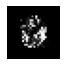

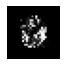

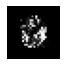

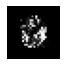

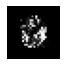

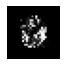

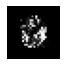

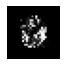

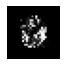

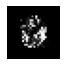

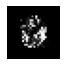

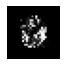

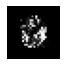

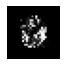

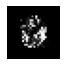

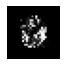

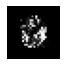

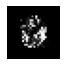

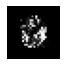

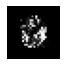

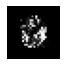

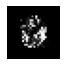

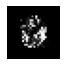

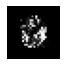

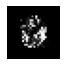

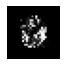

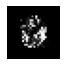

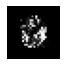

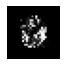

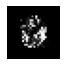

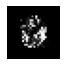

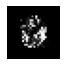

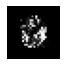

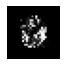

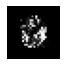

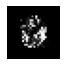

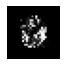

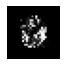

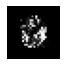

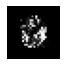

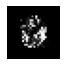

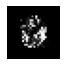

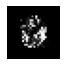

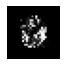

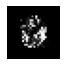

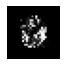

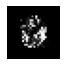

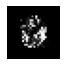

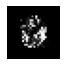

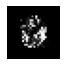

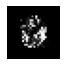

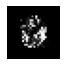

In [ ]:
#Tried a different approach
sess = tf.Session()
sess.run(tf.global_variables_initializer())

i=0

for it in range(10000):
  if it % 100 == 0:
     samples=sess.run(gen_sample)
     fig=plot(samples)
     i+=1
     plt.show()



In [ ]:
gen_sample = gen_sample.eval(session=tf.compat.v1.Session())

Q: Please suggest some modifications that you can apply to increase the convergence speed of the model

Answer:We could improve GAN performance by :
Change the cost function for a better optimization goal.

1.   Change the cost function for a better optimization goal.(Feature matching)
2.   Scale image from -1 to 1
2.   Add additional penalties to the cost function to enforce constraints.
3.   Avoiding overconfidence and overfitting.
4.   Better ways of optimizing the model.
5.   Adding labels./ Oneside label smoothening

We could also change the batch size.









